In [1]:
its_jupyter_notebook = True
# %load_ext autoreload
# %autoreload 2

import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from tqdm.notebook import tqdm
from pathlib import Path
import argparse
import math
from scipy import stats
import copy
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from mpl_toolkits.axes_grid1 import make_axes_locatable

sys.path.insert(0, '..')

from util.evaluation import ModelResultsManager, calculate_correlations, balancing_only_for_one_task, obtain_all_model_auc, remove_outliers, map_thermodynamic_columns, obtain_df_auc, replace_outliers_with_nan_and_make_positive, obtain_sr_nosr, map_dataset_to_hp
from util.plot_utils import npv_precision, plot_sr_distributions, calc_metric, plot_tnr_based_on_distance_for_our_model, collect_results_based_on_topbottom_for_all_models, plot_results_based_on_topbottom_for_all_models, plot_results_how_many_repeats_in_pred_pos_for_all_models, plot_metric_confidence_for_all_models, plot_tnr_based_on_distance_for_all_models, plot_confidence_based_on_distance_for_all_models, plot_tnr_for_all_models, quantile_bins, plot_features_vs_risearch2_confidence, plot_heatmap, plot_tnr_recall_for_all_models, plot_correlation_nreads_prob_intsize
from util.model_names_map import map_model_names
from run_compare_models import load_results_new
#from run_compare_models import load_results_new

from config import *
from models.nt_classifier import build as build_model 
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!
    
external_dataset_dir = os.path.join(dataset_files_dir, 'external_dataset', '200_test_tables')

<class 'transformers.tokenization_dna.DNATokenizer'>


In [2]:
checkpoint_dir_paths = []

chkpt_folder = os.path.join(ROOT_DIR, 'checkpoints')

models_to_check = os.listdir(chkpt_folder)
for model_name in models_to_check:
    model_folder = os.path.join(chkpt_folder, model_name)
    test_paris = os.path.join(chkpt_folder, model_name, 'test_results200.csv')
    ricseq = os.path.join(chkpt_folder, model_name, 'ricseq_results200.csv')
    splash = os.path.join(chkpt_folder, model_name, 'splash_results200.csv')
    mario = os.path.join(chkpt_folder, model_name, 'mario_results200.csv')

    if os.path.exists(test_paris) & os.path.exists(ricseq) & os.path.exists(splash) & os.path.exists(mario):
        checkpoint_dir_paths.append(model_folder)

In [3]:
for i in range(1, 2):
    df, name_map = load_results_new(checkpoint_dir_paths[:i], chkpt_folder)

In [4]:
mean_aucHQ = df.filter(['auc_interactors_parisHQ', 'auc_patches_parisHQ', 'auc_interactors_ricseqHQ', 'auc_patches_ricseqHQ'], axis = 1).mean(axis = 1)

mean_tnr = df.filter(['tnr_psoralen', 'tnr_ricseq', 'tnr_paris_mouse', 'tnr_mario'], axis = 1).mean(axis = 1)
mean_prec = df.filter(['precision_psoralen', 'precision_ricseq', 'precision_paris_mouse', 'precision_mario'], axis = 1).mean(axis = 1)
mean_recall = df.filter(['recall_psoralen', 'recall_ricseq', 'recall_paris_mouse', 'recall_mario'], axis = 1).mean(axis = 1)


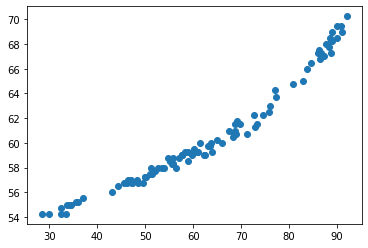

In [5]:
plt.scatter(mean_tnr, mean_prec)

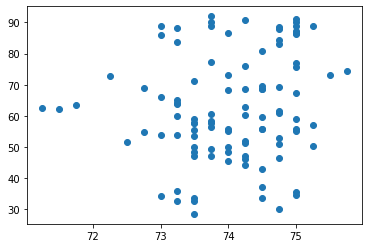

In [6]:
plt.scatter(mean_aucHQ, mean_tnr)

In [10]:
MIN_TNR = 70
MIN_AUC = 75

best_models = df[
    (mean_tnr >= MIN_TNR) &
    (mean_aucHQ >= MIN_AUC)
]

In [11]:
best_models.filter([
    'auc_interactors_parisHQ', 'auc_patches_parisHQ', 
    'auc_interactors_paris_mouse_HQ', 'auc_patches_paris_mouse_HQ',
    'auc_interactors_ricseqHQ', 'auc_patches_ricseqHQ'
], axis = 1)

,auc_interactors_parisHQ,auc_patches_parisHQ,auc_interactors_paris_mouse_HQ,auc_patches_paris_mouse_HQ,auc_interactors_ricseqHQ,auc_patches_ricseqHQ
5,73.0,79.0,60.0,75.0,71.0,77.0
6,74.0,79.0,63.0,76.0,72.0,78.0
44,72.0,79.0,61.0,76.0,71.0,78.0
45,72.0,79.0,58.0,74.0,71.0,78.0
47,73.0,79.0,60.0,76.0,70.0,78.0
50,72.0,79.0,62.0,77.0,71.0,79.0
53,72.0,79.0,62.0,76.0,71.0,78.0
55,73.0,79.0,61.0,76.0,70.0,78.0
63,72.0,80.0,59.0,76.0,70.0,78.0
65,73.0,80.0,60.0,76.0,70.0,77.0


In [12]:
for _, row in best_models.iterrows():
    print(_, name_map[row.model])

5 /data01/giorgio/RNARNA-NT/checkpoints/arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0054
6 /data01/giorgio/RNARNA-NT/checkpoints/arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0057
44 /data01/giorgio/RNARNA-NT/checkpoints/arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0056
45 /data01/giorgio/RNARNA-NT/checkpoints/arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0063
47 /data01/giorgio/RNARNA-NT/checkpoints/arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0030
50 /data01/giorgio/RNARNA-NT/checkpoints/arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0043
53 /data01/giorgio/RNARNA-NT/checkpoints/arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0052
55 /data01/giorgio/RNARNA-NT/checkpoints/arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0062
63 /data01/giorgio/RNARNA-NT/checkpoints/arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight